In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest

In [3]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
SEED = 30

# 1. Import Data

In [6]:
FILE_DIR = '../MoA/lish-moa/'

In [7]:
train_df = pd.read_csv(FILE_DIR+'train_features.csv')
test_df = pd.read_csv(FILE_DIR+'test_features.csv')
target_df = pd.read_csv(FILE_DIR+'train_targets_scored.csv')

In [8]:
print('shape of train_df:{}'.format(train_df.shape))
print('shape of test_df:{}'.format(test_df.shape))
print('shape of target_df:{}'.format(target_df.shape))

shape of train_df:(23814, 876)
shape of test_df:(3982, 876)
shape of target_df:(23814, 207)


In [9]:
train_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


In [11]:
target_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 207 entries, sig_id to wnt_inhibitor
dtypes: int64(206), object(1)
memory usage: 37.6+ MB


In [13]:
GENE = [ col for col in train_df.columns.tolist() if col.startswith('g-')]
CELL = [col for col in train_df.columns.to_list() if col.startswith('c-')]
CAT = [col for col in train_df.columns.tolist() if col.startswith('cp_')]
TARGET = [col for col in target_df.columns.to_list()[1:]]
print('Length of GENE: {}'.format(len(GENE)))
print('Length of CELL: {}'.format(len(CELL)))
print('Length of CAT: {}'.format(len(CAT)))
print('Length of TARGET: {}'.format(len(TARGET)))

Length of GENE: 772
Length of CELL: 100
Length of CAT: 3
Length of TARGET: 206


In [14]:
# check if there is na in train_df
train_df.isna().any().sum()

0

In [15]:
# check if there is na in train_df
target_df.isna().any().sum()

0

# 2. EDA

## 2.1 training data

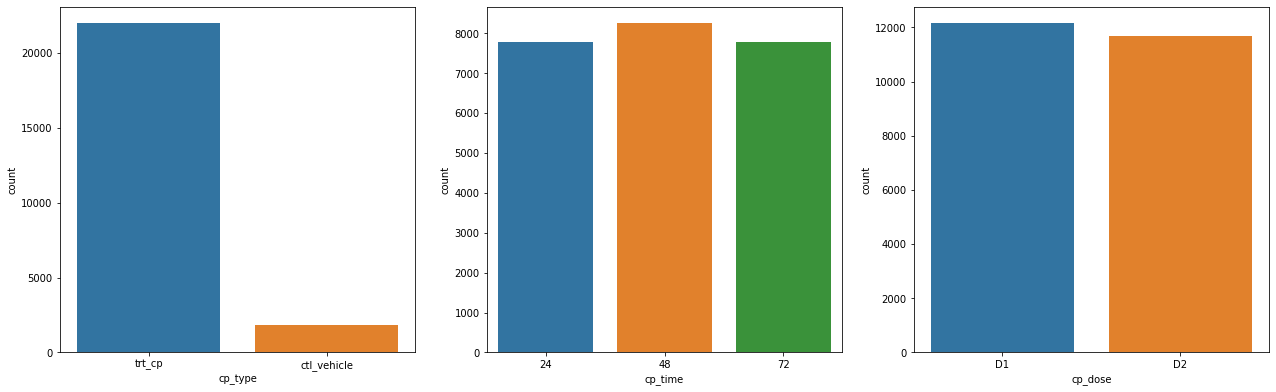

In [16]:
fig ,axs = plt.subplots(1,3,figsize=(14,4))
plt.subplots_adjust(left=-0.1,right=1.1,bottom=-0.1,top=1.1)
for i,col in enumerate(CAT):
    sns.countplot(x=col, data=train_df,ax=axs[i])

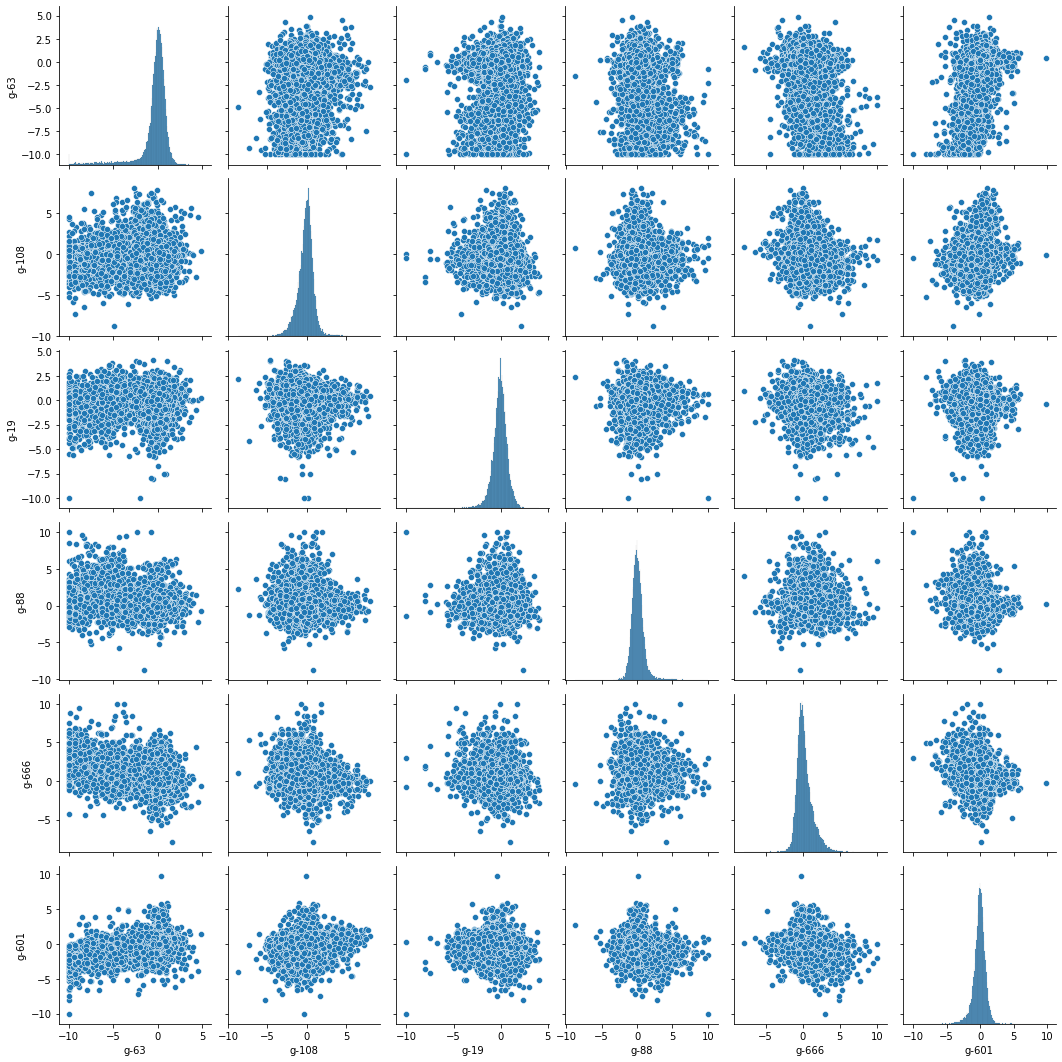

In [34]:
# Draw random gene data 
N = 6 
col = random.choices(GENE,k=N)
plot_df = train_df.loc[:,col]
sns.pairplot(plot_df,diag_kind='hist')
plt.show()

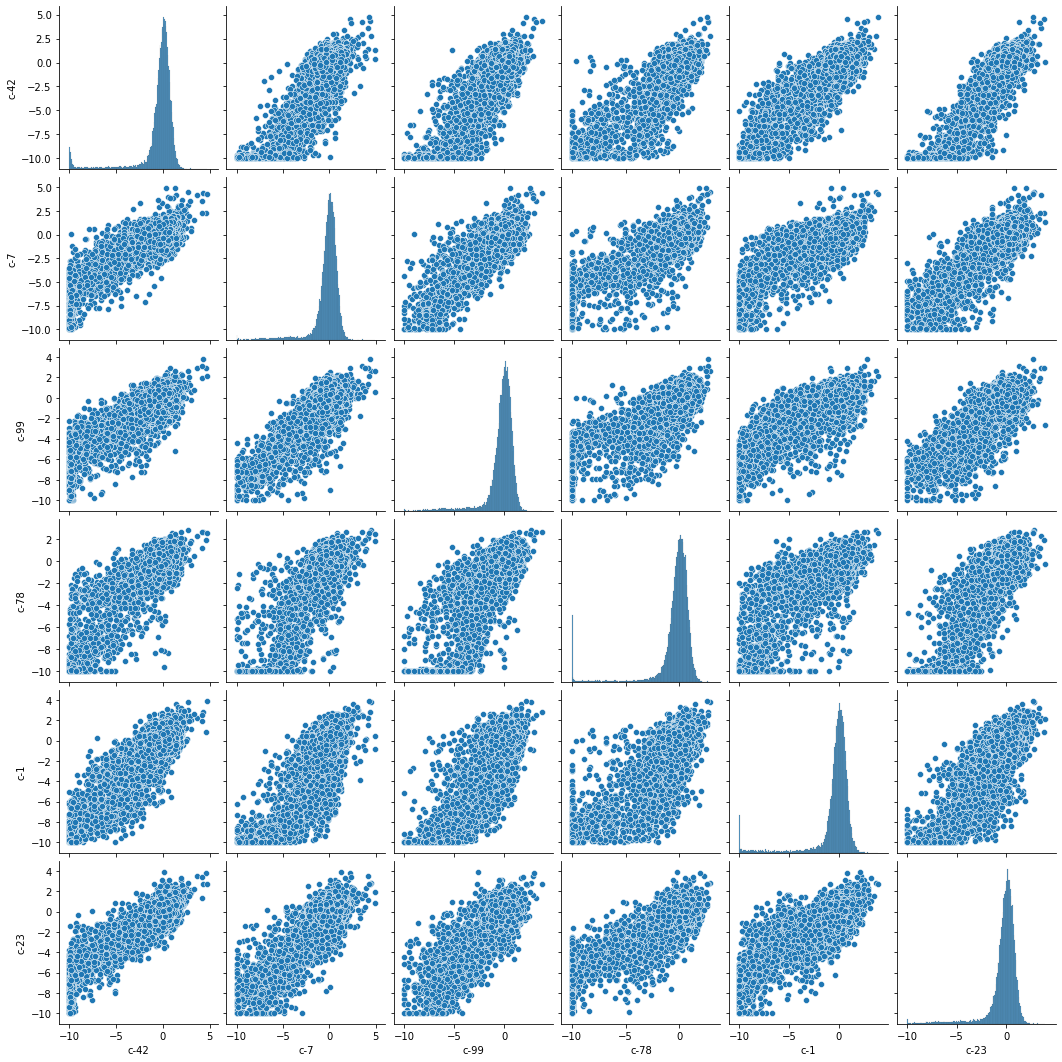

In [17]:
N = 6 
col = random.choices(CELL,k=N)
plot_df = train_df.loc[:,col]
sns.pairplot(plot_df,diag_kind='hist')
plt.show()

## 2.2 Target data 

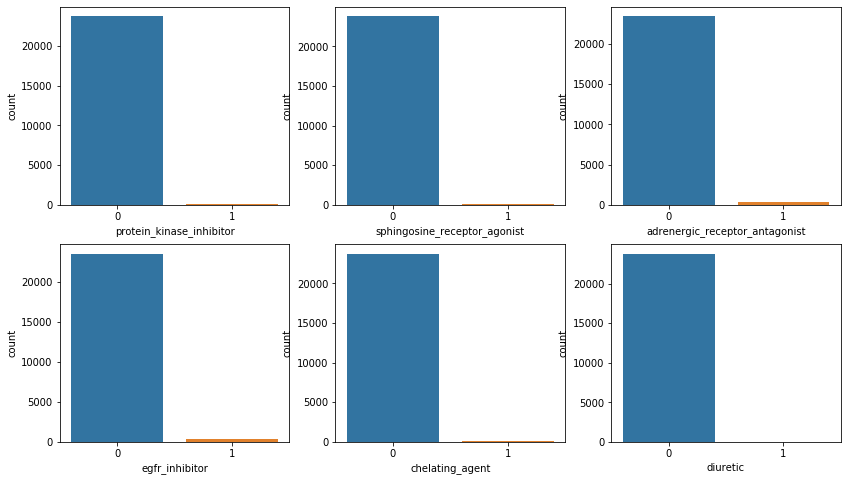

In [36]:
N=6

col = random.choices(TARGET,k=N)

fig =plt.figure(figsize=(14,8))

for i,v in enumerate(col):
    plt.subplot(2,3,i+1)
    sns.countplot(x=v,data=target_df)


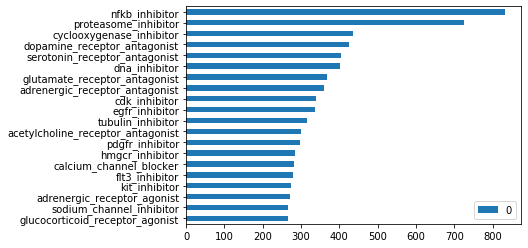

In [18]:
plt_df = pd.DataFrame(target_df.iloc[:,1:].sum(axis=0).sort_values())
plt_df.tail(20).plot(kind='barh')

In [19]:
(target_df[TARGET].sum(axis=0)).sum()/206

81.76699029126213

## 2.3 Merge Data

In [20]:
# drop ctl_vehicle
drop_inx = train_df[train_df['cp_type']=='ctl_vehicle'].index.tolist()
train_df = train_df.drop(index=drop_inx,axis=0).reset_index(drop=True)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21948 entries, 0 to 21947
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 146.7+ MB


In [22]:
# drop ctl_vehicle
target_df = target_df.drop(index=drop_inx,axis=0).reset_index(drop=True)

### 2.3.1 Start Merging

In [23]:
data_df = train_df.join(target_df.set_index('sig_id'),on='sig_id',how='inner')
data_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,0


In [43]:
data_df.drop('sig_id',axis=1,inplace=True)
data_df.drop('cp_type',axis=1,inplace=True)
data_df.head()

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,...,0,0,0,0,0,0,0,0,0,0
1,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,...,0,0,0,0,0,0,0,0,0,0
2,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,...,0,0,0,0,0,0,0,0,0,0
3,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,...,0,0,0,0,0,0,0,0,0,0
4,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,...,0,0,0,0,0,0,0,0,0,0


## 2.4 PCA 

In [44]:
N =500
pca_pipe = Pipeline([
    ('qt',QuantileTransformer(output_distribution='normal')),
    ('pca',PCA(n_components=N))
])

In [45]:
def get_comp_num(data,n,threshold):
    
    '''return specific component_num over variance explaination ratio'''
    
    pca_pipe = Pipeline([
        ('qt',QuantileTransformer(output_distribution='normal')),
        ('pca',PCA(n_components=n))
    ])
    
    pca_pipe.fit_transform(data)
    #check explained ratio
    ratio = pca_pipe.steps[1][1].explained_variance_ratio_.cumsum()
    for i,v in enumerate(ratio):
        if v>threshold:
            d=i+1
            break
    return d

In [46]:
d_GENE = get_comp_num(data_df.loc[:,GENE],n=700,threshold=0.85)
d_GENE

378

In [47]:
d_CELL = get_comp_num(data_df.loc[:,CELL],n=90,threshold=0.85)

d_CELL

58

# 3. Preprocess

In [48]:
gene_pipe = Pipeline([
    ('qt',QuantileTransformer(output_distribution='normal')),
    ('pca',PCA(n_components= d_GENE))
])

gene_union = FeatureUnion([
    ('pca',gene_pipe),
    ('qt',QuantileTransformer(output_distribution='normal'))
])

cell_pipe = Pipeline([
    ('qt',QuantileTransformer(output_distribution='normal')),
    ('pca',PCA(n_components= d_CELL))
])

cell_union = FeatureUnion([
    ('pca',cell_pipe),
    ('qt',QuantileTransformer(output_distribution='normal'))
])

cat_pipe = Pipeline([
    ('ohc',OneHotEncoder())
])

CAT = ['cp_time','cp_dose']
pre_pipe = ColumnTransformer([
    ('GENE',gene_union,GENE),
    ('CELL',cell_union,CELL),
    ('CAT',cat_pipe,CAT)
])

## 4.2 Callbacks

In [49]:
from tensorflow.keras import backend 
label_smooth = 0.001
p_min = 0*(1-label_smooth)+label_smooth/2
p_max = 1*(1-label_smooth)+label_smooth/2
# p_min =0.001
# p_max = 0.999

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

### 4.3.1 initial bias 

In [50]:
total = data_df.shape[0]
pos = data_df[TARGET].sum(axis=0).values
neg = (pos-total)*(-1)

initial_bias = np.log(pos/neg)

init = tf.constant_initializer(initial_bias)

## 4.1 build NN

In [51]:
callbacks = []
# lr 
# def exponential_decay(lr0, s):
#     def exponential_decay_fn(epoch):
#         return lr0 * 0.1**(epoch / s) 
#     return exponential_decay_fn
# exponential_decay_fn = exponential_decay(lr0=0.01, s=5)
# lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# callbacks.append(lr_scheduler)

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler,verbose=0)
callbacks.append(lr_scheduler)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_logloss', 
#                                                  factor=0.1, 
#                                                  verbose=1,
#                                                  mode='min',
#                                                  patience=5,
#                                                  min_lr=1e-7)
# callbacks.append(reduce_lr)

# check point 
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",monitor='val_logloss', save_best_only=True)
callbacks.append(checkpoint_cb)


# early stop
early_st = tf.keras.callbacks.EarlyStopping(monitor='val_logloss',
                                            min_delta=1E-5,
                                            patience=7,
                                            verbose=0,
                                            mode='min',
                                            baseline=None,
                                            restore_best_weights=True)
callbacks.append(early_st)

# lr record 
# class LearningRateLoggingCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch):
#         lr = self.model.optimizer.lr
#         tf.summary.scalar('learning rate', data=lr, step=epoch)
        
# callbacks.append(LearningRateLoggingCallback())        
# Tensorboard 
# root_logdir = os.path.join(os.curdir, "my_logs")

# def get_run_logdir(): 
#     import time
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") 
#     return os.path.join(root_logdir, run_id)

# run_logdir = get_run_logdir()
    
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
# callbacks.append(tensorboard_cb)

In [52]:
import tensorflow_addons as tfa

def build_NN(n_hiddens,n_neurons,drop_rate=0.2,inputshape=447,smooth_rate=0.001,lr=3e-4):
    
    #adam = tfa.optimizers.Lookahead(tf.optimizers.Adam(learning_rate=lr,beta_1=0.9,beta_2=0.999),sync_period = 10)
    adam = tf.optimizers.Adam(learning_rate=lr,beta_1=0.9,beta_2=0.999)
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.Input(shape=(inputshape,)))
    
    for i in range(n_hiddens):
        
        model.add(keras.layers.BatchNormalization())
        
#         model.add(tfa.layers.WeightNormalization(keras.layers.Dense(n_neurons,activation="relu", 
#                                      kernel_initializer="he_normal",
#                                      kernel_regularizer=keras.regularizers.l2(0.01))))
        
        model.add(keras.layers.Dense(n_neurons,activation="relu", 
                                      kernel_initializer="he_normal",
                                      kernel_regularizer=keras.regularizers.l2(0.01)))
        
        model.add(keras.layers.Dropout(rate = drop_rate))
    
      
    model.add(keras.layers.Dense(206,activation='sigmoid',bias_initializer=init))
    
    model.compile(loss = keras.losses.BinaryCrossentropy(label_smoothing=smooth_rate),
                  optimizer=adam,metrics=logloss)

    return model

In [53]:
n_folds = 5
mlkf = MultilabelStratifiedKFold(n_splits=n_folds,shuffle=True,random_state=SEED)
results = []
oof = tf.constant(0.0)
np.random.seed(SEED)
n_seeds=5
seeds = np.random.randint(0,100,size=n_seeds)
for seed in seeds:
    mskf = MultilabelStratifiedKFold(n_splits=n_folds,shuffle=True,random_state=seed)
    for n,(train, test) in enumerate(mlkf.split(data_df.loc[:,CAT+GENE+CELL],data_df[TARGET])):
            print('fold{}'.format(n))
            train_x = pre_pipe.fit_transform(data_df.loc[train,CAT+GENE+CELL])
            val_x = pre_pipe.transform(data_df.loc[test,CAT+GENE+CELL])
            test_x = pre_pipe.transform(test_df.loc[:,CAT+GENE+CELL])
            train_y = data_df.loc[train,TARGET]
            val_y = data_df.loc[test,TARGET]


            model = build_NN(n_hiddens=3, 
                             n_neurons=1024,
                             lr=0.0003,
                             drop_rate=0.45,
                             inputshape=train_x.shape[1])

            hist = model.fit(train_x,train_y, 
                             batch_size=128,
                             epochs=200,
                             validation_data = (val_x,val_y),
                             callbacks =callbacks,
                             verbose=0
                             # test 

                            )
            pred_y = model.predict(val_x)
            oof += logloss(tf.constant(val_y,dtype=tf.float32),tf.constant(pred_y,dtype=tf.float32))/(n_folds*n_seeds)
            print(oof)

            results.append(model.predict(test_x))
        
        

/Users/scleeza/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/scleeza/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=37 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


fold0
tf.Tensor(0.00075528235, shape=(), dtype=float32)
fold1
tf.Tensor(0.001518043, shape=(), dtype=float32)
fold2
tf.Tensor(0.002279556, shape=(), dtype=float32)
fold3
tf.Tensor(0.0030401289, shape=(), dtype=float32)
fold4
tf.Tensor(0.0037997514, shape=(), dtype=float32)


/Users/scleeza/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=37 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


fold0
tf.Tensor(0.004555964, shape=(), dtype=float32)
fold1
tf.Tensor(0.005318074, shape=(), dtype=float32)
fold2
tf.Tensor(0.006081058, shape=(), dtype=float32)
fold3
tf.Tensor(0.00684179, shape=(), dtype=float32)
fold4


KeyboardInterrupt: 

In [ ]:
a=np.zeros_like(results[0])
for i in results:
    a+=tf.clip_by_value(i,p_min,p_max).numpy()

a=a/(n_folds*n_seeds)


submission_df = pd.DataFrame(a,columns=TARGET)
submission_df = pd.concat([test_df.loc[:,['sig_id']],submission_df],axis=1)
submission_df.to_csv('submission.csv', index=False)

In [ ]:
a=np.zeros_like(results[0])
for i in results:
    a+=i

a = a/(n_folds*n_seeds)
a= tf.clip_by_value(i,p_min,p_max).numpy()

submission_df = pd.DataFrame(a,columns=TARGET)
submission_df = pd.concat([test_df.loc[:,['sig_id']],submission_df],axis=1)
submission_df.to_csv('submission.csv', index=False)